In [48]:
import os
print(os.getcwd())
rdir='/home/hyeryungson'
os.chdir(os.path.join(rdir, 'mucoco/notebooks'))
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import torch
from torch.nn import Softmax
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import DataCollatorWithPadding

from utils.load_ckpt import define_model

import json
import argparse
import time
from itertools import chain
from tqdm import tqdm


/home/hyeryungson/mucoco


In [97]:
os.chdir(os.path.join(rdir, 'mucoco'))

In [3]:
# set gpu (template code)
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # Arrange GPU devices starting from 0
os.environ["CUDA_VISIBLE_DEVICES"]= "0"  # Set the GPU 0 to use

In [49]:
BATCH_SIZE=64
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Which cpu/cuda?: {DEVICE}")
print(f"Which device?: {torch.cuda.current_device()}")

Which cpu/cuda?: cuda
Which device?: 0


In [83]:
# define dataset, dataloader
# toxicity_data = load_dataset("csv", data_files="./notebooks/results/test_mucoco+add_preds2.csv")
toxicity_data = load_dataset("json", data_files="../data/toxicity/jigsaw-unintended-bias-in-toxicity-classification/fine-grained/train.jsonl")

Found cached dataset json (/home/hyeryungson/.cache/huggingface/datasets/json/default-e29a261c4ec3cef6/0.0.0/fe5dd6ea2639a6df622901539cb550cf8797e5a6b2dd7af1cf934bed8e233e6e)


  0%|          | 0/1 [00:00<?, ?it/s]

In [57]:
# load trained model
checkpoint='/home/hyeryungson/mucoco/models/models_balanced/roberta-base-jigsaw-toxicity-classifier-with-gpt2-large-embeds/checkpoint_best/pytorch_model.bin' # balanced
model, tokenizer = define_model(checkpoint, output_attentions=True)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2-large and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializin

DEVICE:  cuda


In [58]:
# # 논문에서는 gpt-2의 tokenizer를 사용하였으므로, mask token이 기존에는 없었음
# print(tokenizer.all_special_ids, tokenizer.all_special_tokens, tokenizer.vocab_size)

# # tokenizer에 mask token 추가
# print('add mask token')
# SPECIAL_TOKENS = {"mask_token": "<mask>"}
# tokenizer.add_special_tokens(SPECIAL_TOKENS)

# print(tokenizer.all_special_ids, tokenizer.all_special_tokens, tokenizer.vocab_size)

In [84]:
def tokenize_function(example):
    return tokenizer(example["text"], truncation=True)

tokenized_dataset=toxicity_data.map(tokenize_function, batched=True)

Map:   0%|          | 0/46718 [00:00<?, ? examples/s]

In [85]:
# remove unnecessary columns
# tokenized_dataset = tokenized_dataset.remove_columns(["text", 'pred_binarize', 'pred_balanced', 'pred_add', 'pred_addmore', 'pred_binary'])
tokenized_dataset = tokenized_dataset.remove_columns(["text"])
tokenized_dataset = tokenized_dataset.rename_column("toxicity", "labels")
tokenized_dataset.set_format("torch")
tokenized_dataset["train"].column_names

['labels', 'input_ids', 'attention_mask']

In [90]:
# tokenized_dataset_subset = tokenized_dataset["train"].filter(lambda x: (x["labels"]>=0.9) and (x["labels"]<1.0))
tokenized_dataset_subset = tokenized_dataset["train"].filter(lambda x: (x["labels"]==1.0))

Filter:   0%|          | 0/46718 [00:00<?, ? examples/s]

In [92]:
# build data loader
batch_size = 32
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
subset_dataloader = DataLoader(
    dataset=tokenized_dataset_subset, shuffle=False, batch_size=batch_size, collate_fn=data_collator
)

In [93]:
layer_num=10
cls_attns_soft_list = []
input_id_list = []
labels_list = []
preds_list = []
model.eval()
for batch in subset_dataloader:
    batch = {k: v.to(DEVICE) for k, v in batch.items()} # move training data to gpu
    with torch.no_grad():
        outputs = model.forward(
            batch["input_ids"],
            attention_mask=batch["attention_mask"],
        )
    attentions = outputs["attentions"][layer_num]
    cls_attns = attentions.max(1)[0][:, 0]
    cls_attns[cls_attns==0.0] = -float("inf")
    cls_attns_soft = cls_attns.softmax(-1)
    cls_attns_soft_list.append(cls_attns_soft)
    input_id_list.append(batch["input_ids"])
    labels_list.append(batch["labels"])
    preds_list.append(outputs["logits"].softmax(-1)[:,1])

Batch:  0
./notebooks/XAI/fig/layer10_gt1.000_pred0.926_ix0.png


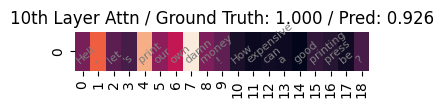

./notebooks/XAI/fig/layer10_gt1.000_pred0.783_ix1.png


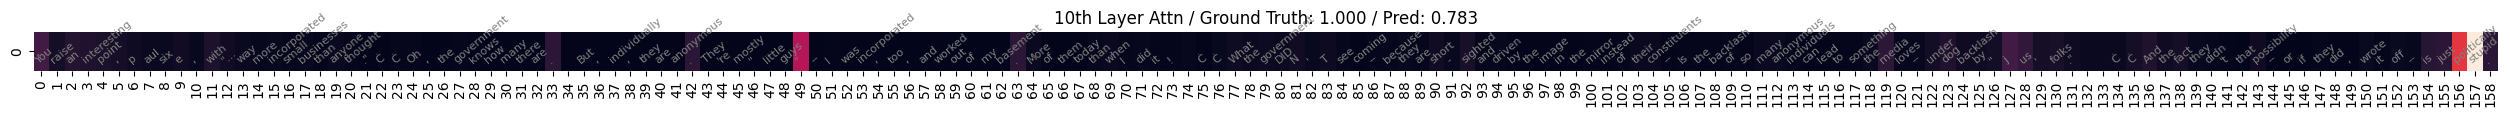

./notebooks/XAI/fig/layer10_gt1.000_pred0.830_ix2.png


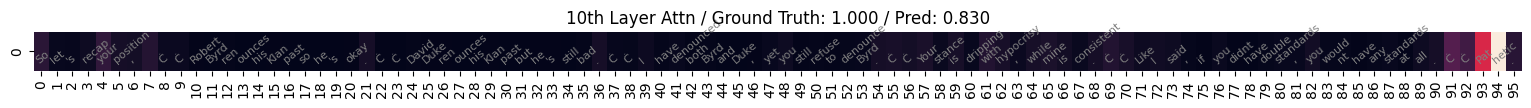

./notebooks/XAI/fig/layer10_gt1.000_pred0.793_ix3.png


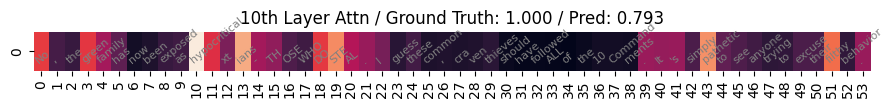

./notebooks/XAI/fig/layer10_gt1.000_pred0.810_ix4.png


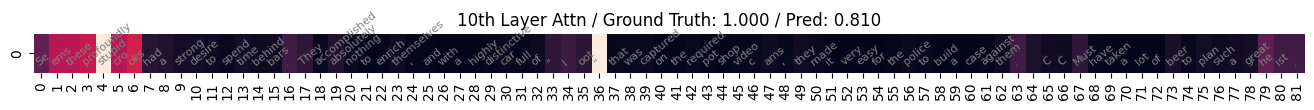

./notebooks/XAI/fig/layer10_gt1.000_pred0.883_ix5.png


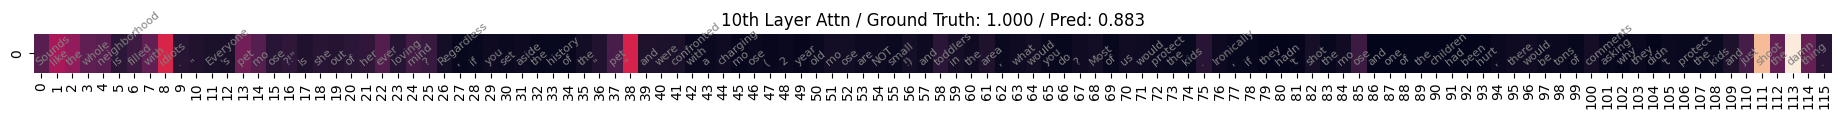

./notebooks/XAI/fig/layer10_gt1.000_pred0.842_ix6.png


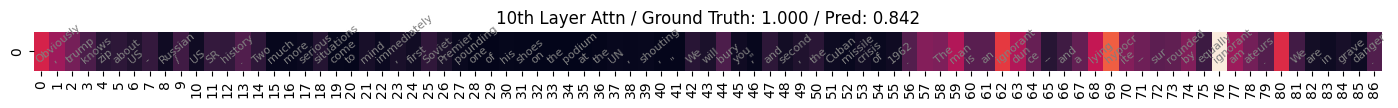

./notebooks/XAI/fig/layer10_gt1.000_pred0.748_ix7.png


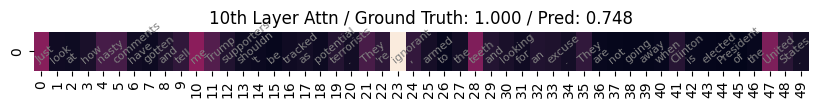

./notebooks/XAI/fig/layer10_gt1.000_pred0.838_ix8.png


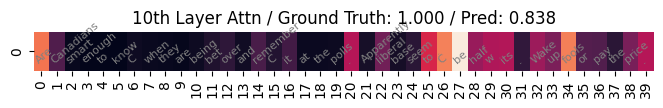

./notebooks/XAI/fig/layer10_gt1.000_pred0.758_ix9.png


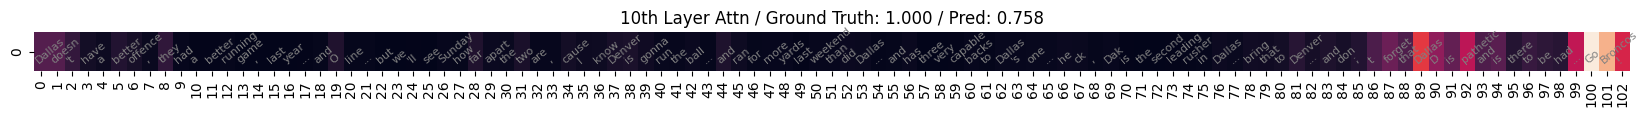

./notebooks/XAI/fig/layer10_gt1.000_pred0.640_ix10.png


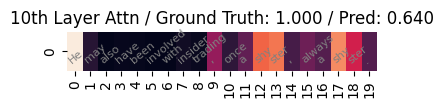

./notebooks/XAI/fig/layer10_gt1.000_pred0.831_ix11.png


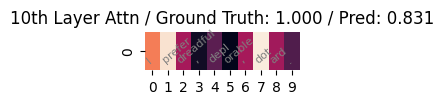

./notebooks/XAI/fig/layer10_gt1.000_pred0.808_ix12.png


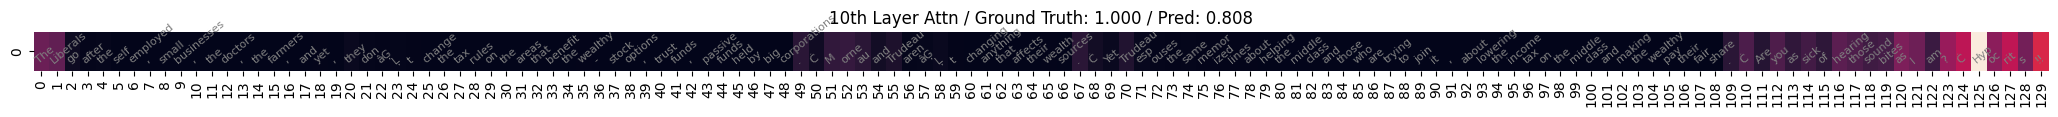

./notebooks/XAI/fig/layer10_gt1.000_pred0.729_ix13.png


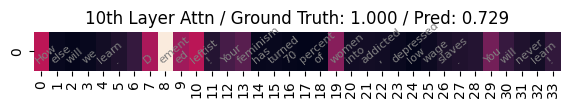

./notebooks/XAI/fig/layer10_gt1.000_pred0.843_ix14.png


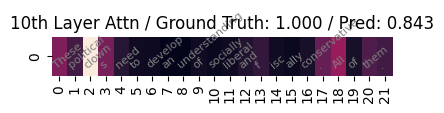

./notebooks/XAI/fig/layer10_gt1.000_pred0.703_ix15.png


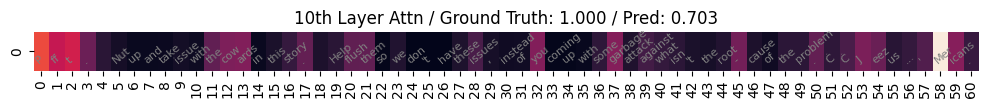

./notebooks/XAI/fig/layer10_gt1.000_pred0.824_ix16.png


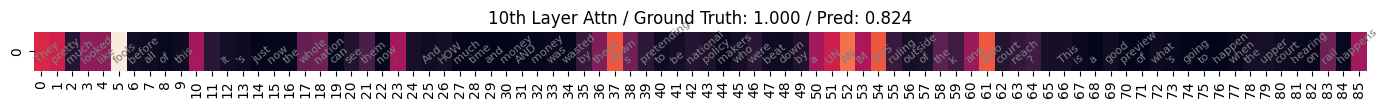

./notebooks/XAI/fig/layer10_gt1.000_pred0.858_ix17.png


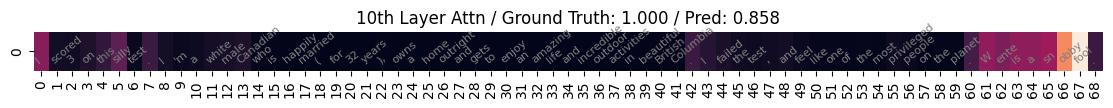

./notebooks/XAI/fig/layer10_gt1.000_pred0.827_ix18.png


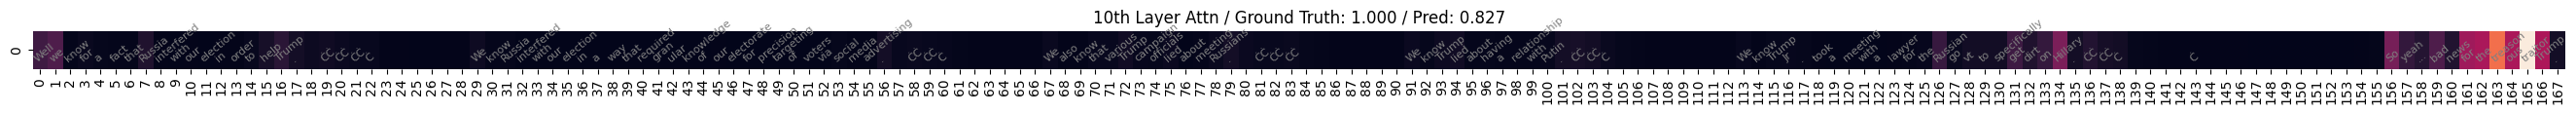

./notebooks/XAI/fig/layer10_gt1.000_pred0.713_ix19.png


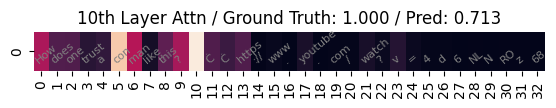

./notebooks/XAI/fig/layer10_gt1.000_pred0.667_ix20.png


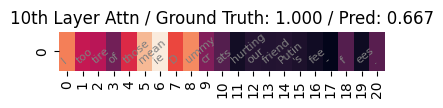

./notebooks/XAI/fig/layer10_gt1.000_pred0.842_ix21.png


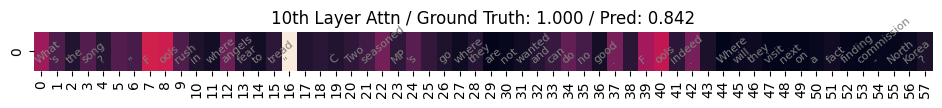

./notebooks/XAI/fig/layer10_gt1.000_pred0.845_ix22.png


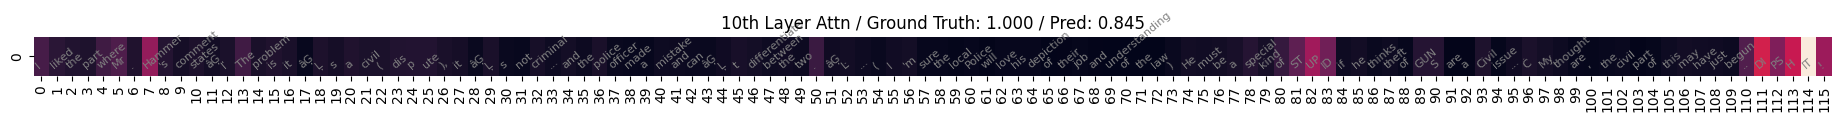

./notebooks/XAI/fig/layer10_gt1.000_pred0.799_ix23.png


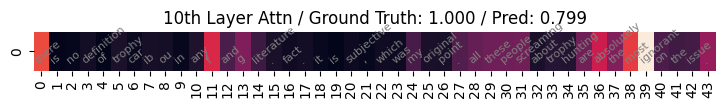

./notebooks/XAI/fig/layer10_gt1.000_pred0.696_ix24.png


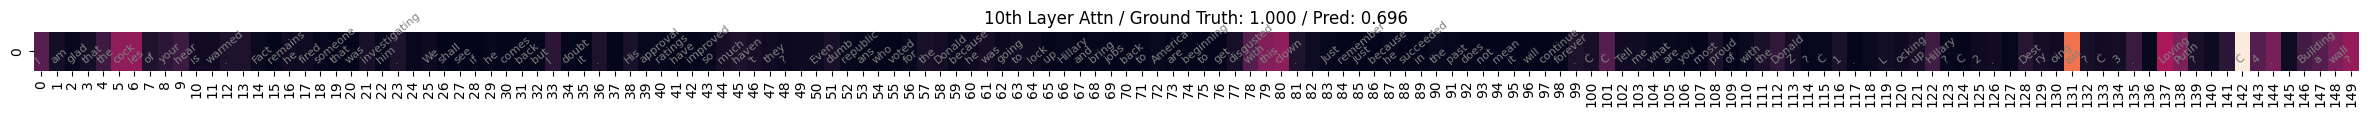

./notebooks/XAI/fig/layer10_gt1.000_pred0.787_ix25.png


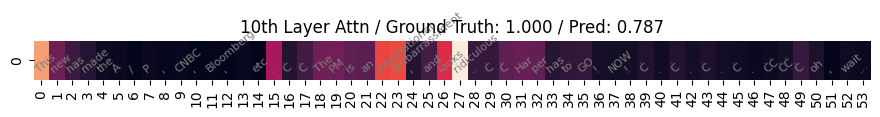

./notebooks/XAI/fig/layer10_gt1.000_pred0.739_ix26.png


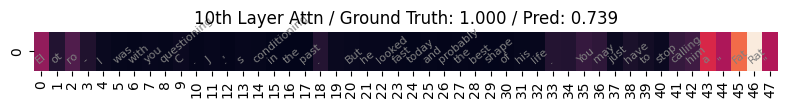

./notebooks/XAI/fig/layer10_gt1.000_pred0.725_ix27.png


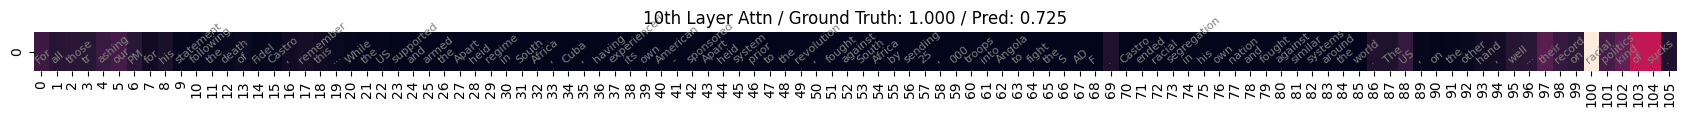

./notebooks/XAI/fig/layer10_gt1.000_pred0.753_ix28.png


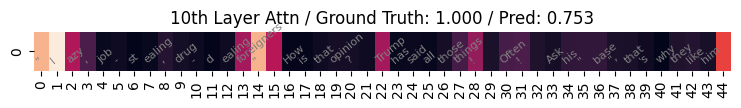

./notebooks/XAI/fig/layer10_gt1.000_pred0.805_ix29.png


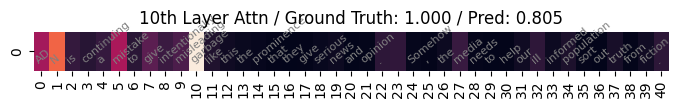

./notebooks/XAI/fig/layer10_gt1.000_pred0.769_ix30.png


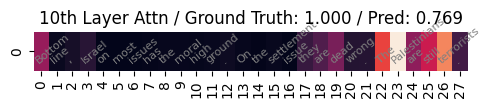

./notebooks/XAI/fig/layer10_gt1.000_pred0.806_ix31.png


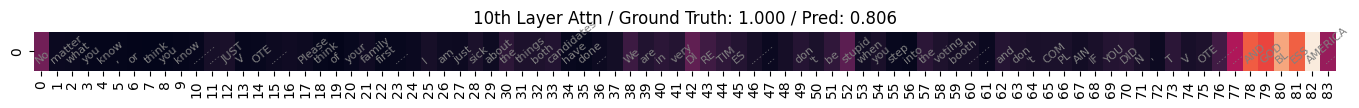

Batch:  1
./notebooks/XAI/fig/layer10_gt1.000_pred0.674_ix32.png


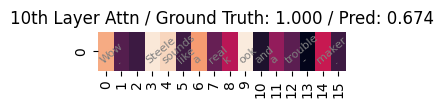

./notebooks/XAI/fig/layer10_gt1.000_pred0.867_ix33.png


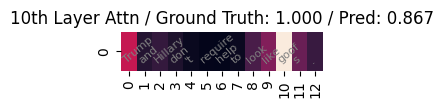

./notebooks/XAI/fig/layer10_gt1.000_pred0.921_ix34.png


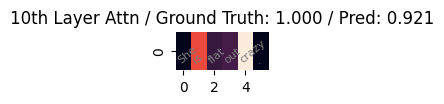

./notebooks/XAI/fig/layer10_gt1.000_pred0.761_ix35.png


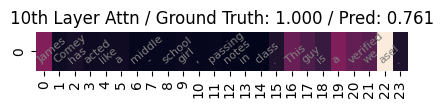

./notebooks/XAI/fig/layer10_gt1.000_pred0.816_ix36.png


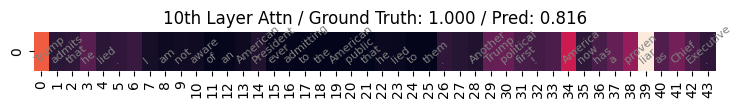

./notebooks/XAI/fig/layer10_gt1.000_pred0.897_ix37.png


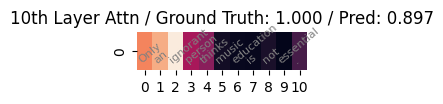

./notebooks/XAI/fig/layer10_gt1.000_pred0.811_ix38.png


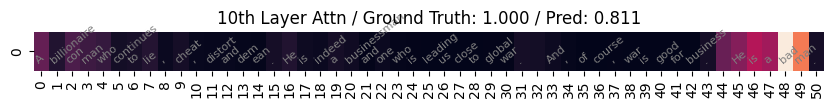

./notebooks/XAI/fig/layer10_gt1.000_pred0.765_ix39.png


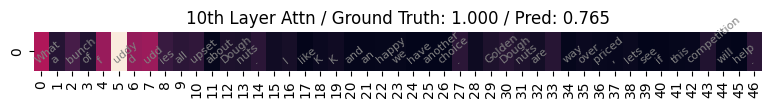

./notebooks/XAI/fig/layer10_gt1.000_pred0.776_ix40.png


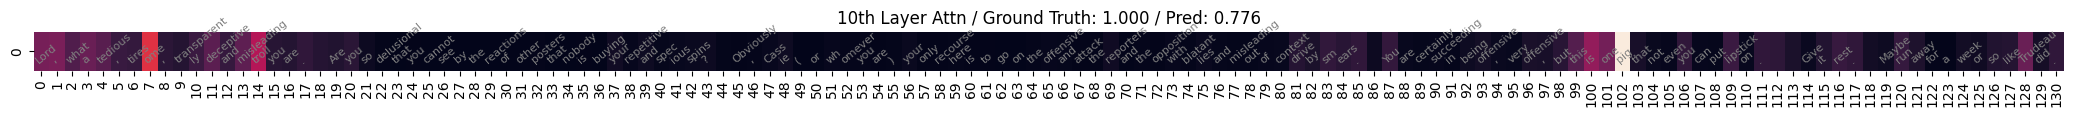

./notebooks/XAI/fig/layer10_gt1.000_pred0.722_ix41.png


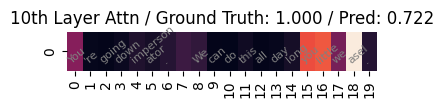

./notebooks/XAI/fig/layer10_gt1.000_pred0.797_ix42.png


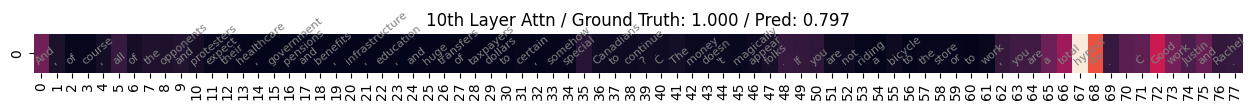

./notebooks/XAI/fig/layer10_gt1.000_pred0.790_ix43.png


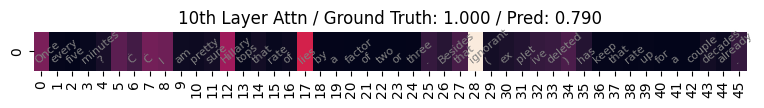

./notebooks/XAI/fig/layer10_gt1.000_pred0.609_ix44.png


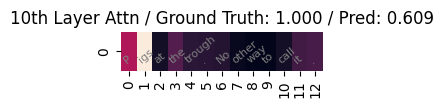

./notebooks/XAI/fig/layer10_gt1.000_pred0.850_ix45.png


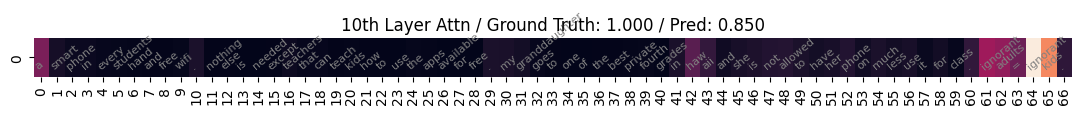

./notebooks/XAI/fig/layer10_gt1.000_pred0.850_ix46.png


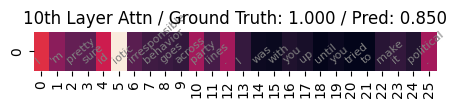

./notebooks/XAI/fig/layer10_gt1.000_pred0.816_ix47.png


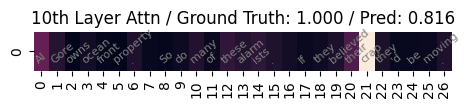

./notebooks/XAI/fig/layer10_gt1.000_pred0.745_ix48.png


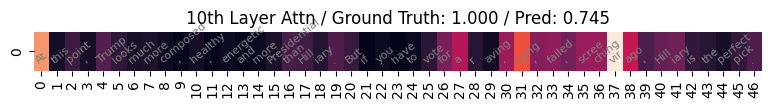

./notebooks/XAI/fig/layer10_gt1.000_pred0.907_ix49.png


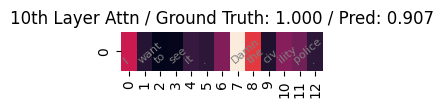

./notebooks/XAI/fig/layer10_gt1.000_pred0.915_ix50.png


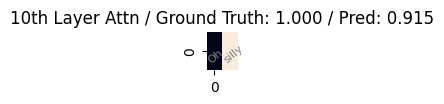

./notebooks/XAI/fig/layer10_gt1.000_pred0.841_ix51.png


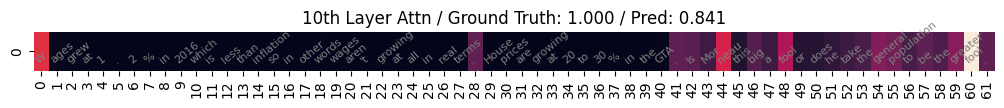

./notebooks/XAI/fig/layer10_gt1.000_pred0.701_ix52.png


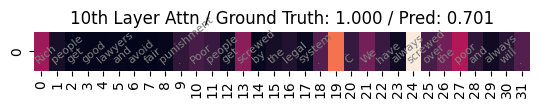

./notebooks/XAI/fig/layer10_gt1.000_pred0.790_ix53.png


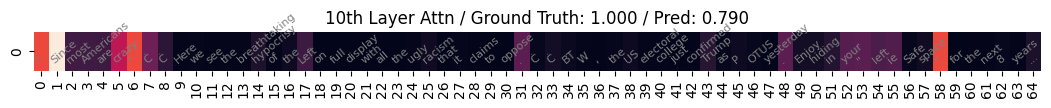

./notebooks/XAI/fig/layer10_gt1.000_pred0.602_ix54.png


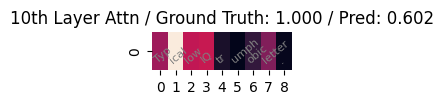

./notebooks/XAI/fig/layer10_gt1.000_pred0.815_ix55.png


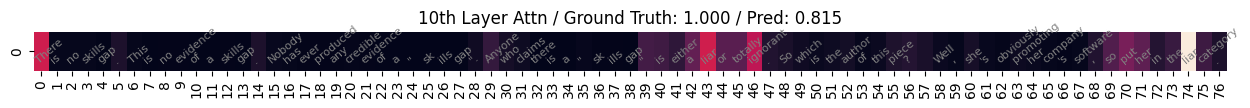

./notebooks/XAI/fig/layer10_gt1.000_pred0.818_ix56.png


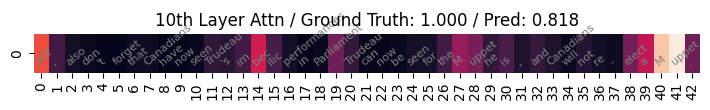

./notebooks/XAI/fig/layer10_gt1.000_pred0.609_ix57.png


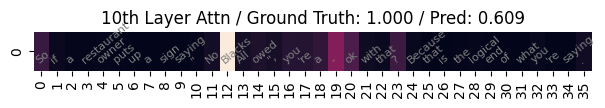

./notebooks/XAI/fig/layer10_gt1.000_pred0.887_ix58.png


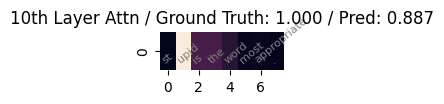

./notebooks/XAI/fig/layer10_gt1.000_pred0.455_ix59.png


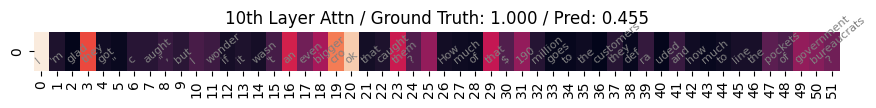

./notebooks/XAI/fig/layer10_gt1.000_pred0.810_ix60.png


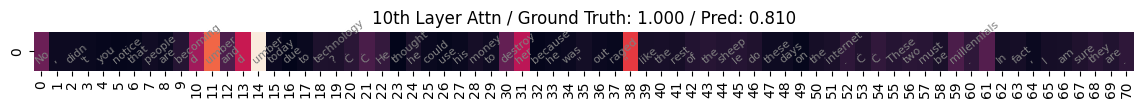

./notebooks/XAI/fig/layer10_gt1.000_pred0.818_ix61.png


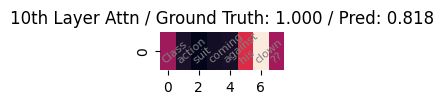

./notebooks/XAI/fig/layer10_gt1.000_pred0.837_ix62.png


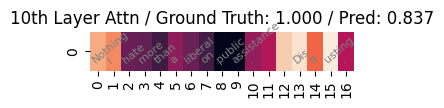

./notebooks/XAI/fig/layer10_gt1.000_pred0.827_ix63.png


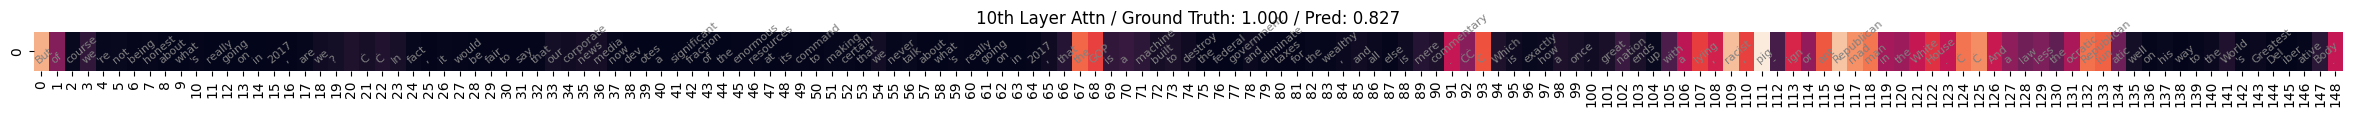

Batch:  2
./notebooks/XAI/fig/layer10_gt1.000_pred0.801_ix64.png


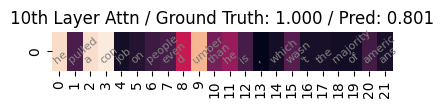

./notebooks/XAI/fig/layer10_gt1.000_pred0.817_ix65.png


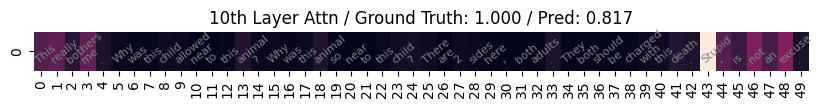

./notebooks/XAI/fig/layer10_gt1.000_pred0.786_ix66.png


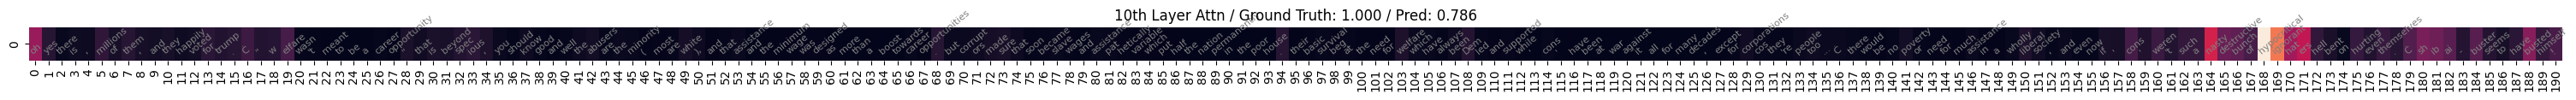

./notebooks/XAI/fig/layer10_gt1.000_pred0.852_ix67.png


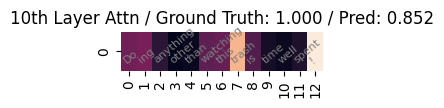

./notebooks/XAI/fig/layer10_gt1.000_pred0.851_ix68.png


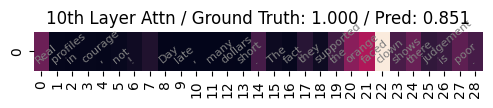

./notebooks/XAI/fig/layer10_gt1.000_pred0.818_ix69.png


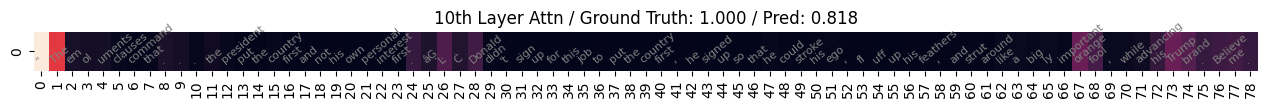

./notebooks/XAI/fig/layer10_gt1.000_pred0.678_ix70.png


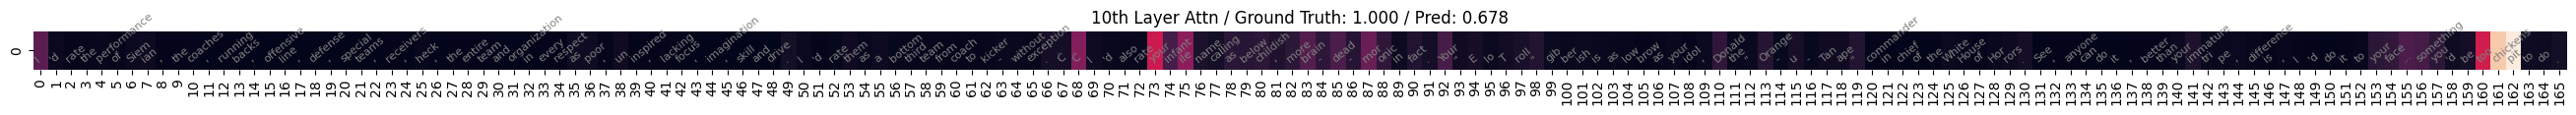

./notebooks/XAI/fig/layer10_gt1.000_pred0.828_ix71.png


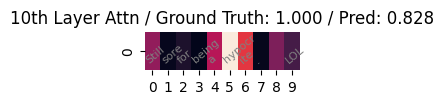

./notebooks/XAI/fig/layer10_gt1.000_pred0.872_ix72.png


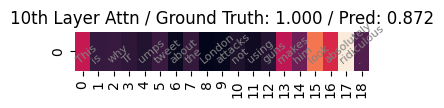

./notebooks/XAI/fig/layer10_gt1.000_pred0.734_ix73.png


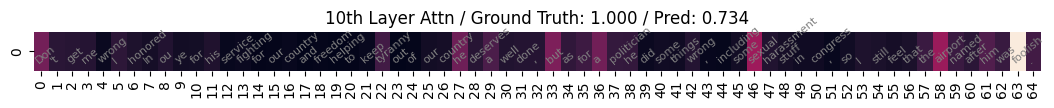

./notebooks/XAI/fig/layer10_gt1.000_pred0.818_ix74.png


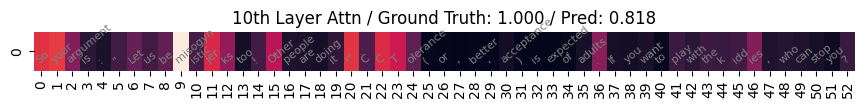

./notebooks/XAI/fig/layer10_gt1.000_pred0.810_ix75.png


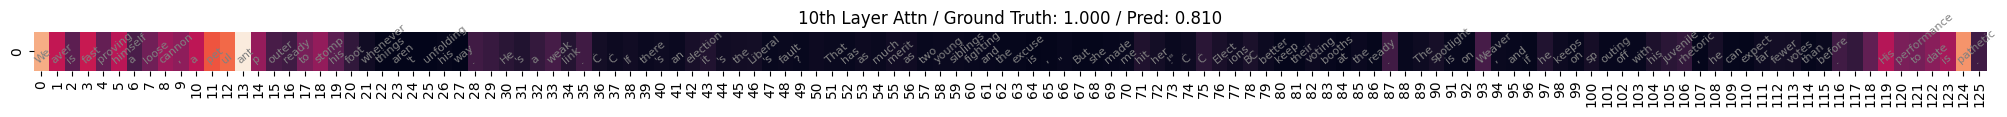

./notebooks/XAI/fig/layer10_gt1.000_pred0.807_ix76.png


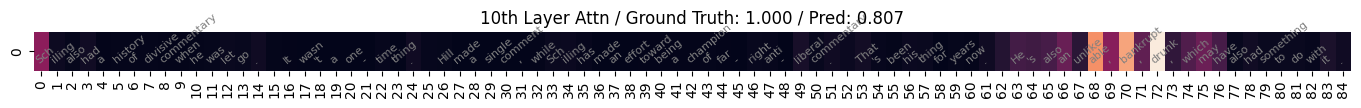

./notebooks/XAI/fig/layer10_gt1.000_pred0.846_ix77.png


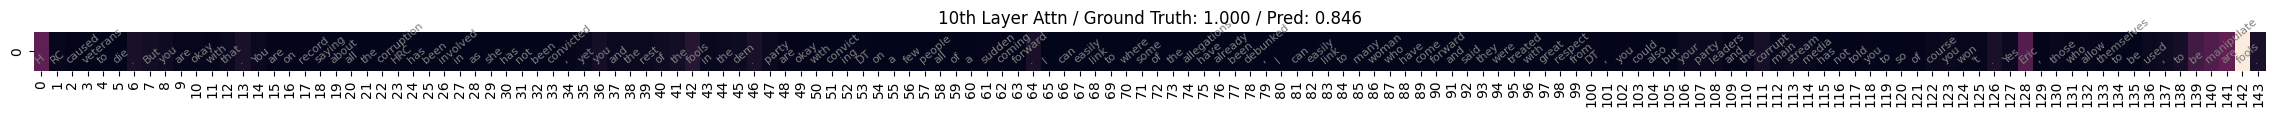

./notebooks/XAI/fig/layer10_gt1.000_pred0.839_ix78.png


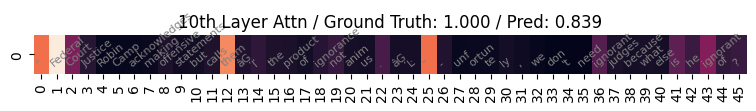

./notebooks/XAI/fig/layer10_gt1.000_pred0.821_ix79.png


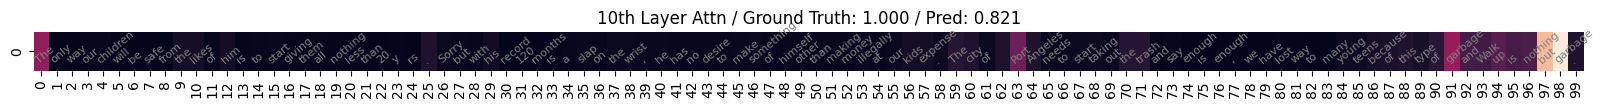

./notebooks/XAI/fig/layer10_gt1.000_pred0.640_ix80.png


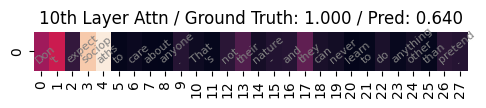

./notebooks/XAI/fig/layer10_gt1.000_pred0.806_ix81.png


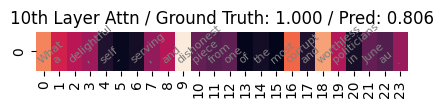

./notebooks/XAI/fig/layer10_gt1.000_pred0.654_ix82.png


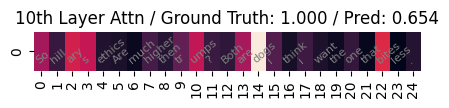

./notebooks/XAI/fig/layer10_gt1.000_pred0.870_ix83.png


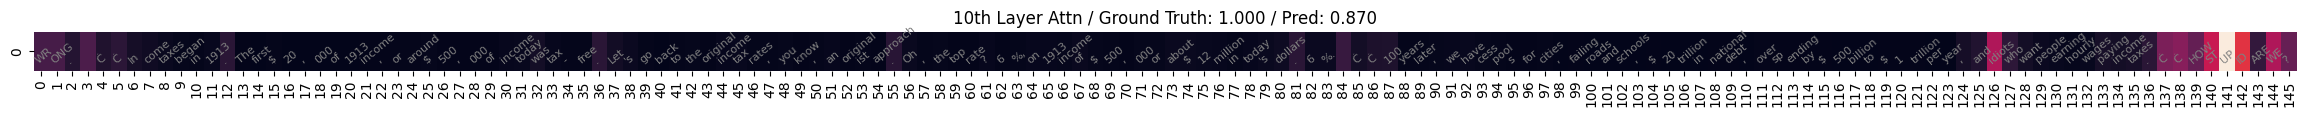

./notebooks/XAI/fig/layer10_gt1.000_pred0.714_ix84.png


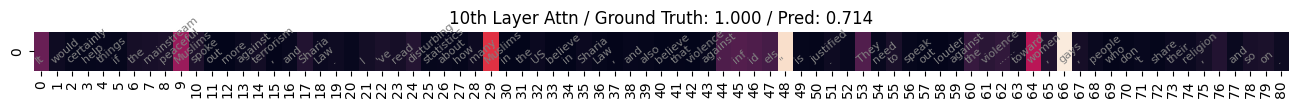

./notebooks/XAI/fig/layer10_gt1.000_pred0.791_ix85.png


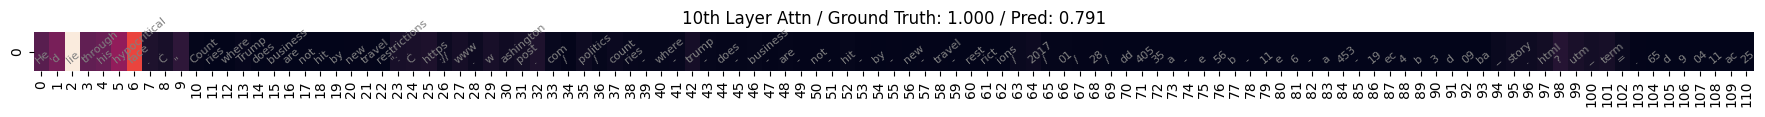

./notebooks/XAI/fig/layer10_gt1.000_pred0.752_ix86.png


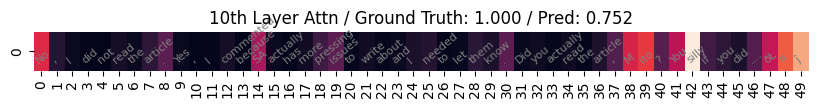

./notebooks/XAI/fig/layer10_gt1.000_pred0.823_ix87.png


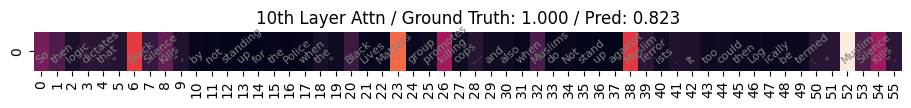

./notebooks/XAI/fig/layer10_gt1.000_pred0.784_ix88.png


ValueError: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

ValueError: 
$$
^
ParseException: Expected end of text, found '$'  (at char 0), (line:1, col:1)

<Figure size 2340x50 with 1 Axes>

In [99]:
# 알게된 사실 attention value의 절대값은 굉장히 균일하다. -> 상대적으로 분석해야 한다. ㅠ
# 밝을 수록 값이 큰 것
for batch_num in range(len(cls_attns_soft_list)):
    print("Batch: ", batch_num)
    for ix in range(len(cls_attns_soft_list[batch_num])):

        attn=cls_attns_soft_list[batch_num][ix][cls_attns_soft_list[batch_num][ix]!=0.0]
        attn=attn.cpu().unsqueeze(0).numpy()
        toks=tokenizer.convert_ids_to_tokens(input_id_list[batch_num][ix][input_id_list[batch_num][ix]!=50256])
        toks=[x.strip('Ġ') for x in toks]

        fig = plt.figure(figsize=(0.2 * len(toks), 0.5))
        # sns.heatmap(attn, cbar=False,vmin=0, vmax=1)
        sns.heatmap(attn, cbar=False)
        for _x in range(attn.shape[-1]):
            plt.text(_x, 0.8, toks[_x], size=8, color='gray', rotation=40)
        plt.title(f"{layer_num}th Layer Attn / Ground Truth: {labels_list[batch_num][ix]:.3f} / Pred: {preds_list[batch_num][ix]:.3f}")
        print(f"./notebooks/XAI/fig/layer{layer_num}_gt{labels_list[batch_num][ix]:.3f}_pred{preds_list[batch_num][ix]:.3f}_ix{ix+32*batch_num}.png")
        plt.savefig(f"./notebooks/XAI/fig/layer{layer_num}_gt{labels_list[batch_num][ix]:.3f}_pred{preds_list[batch_num][ix]:.3f}_ix{ix+32*batch_num}.png",bbox_inches="tight")
        plt.show()